In [1]:
import sys 
sys.path.append('./../../src')

# python shit
from datetime import datetime, timedelta, timezone

# others shit
from matplotlib import pyplot
from pandas import DataFrame
import numpy as np

from lib.finnhub.data import FinnhubData as fh
from lib.oscillators import stochastic

In [2]:
ticker = 'GME'
fh = fh()
data = fh.get_historical_data(ticker, fh.get_daily_closings)

In [3]:
data.describe()

,o,l,h,c,v
count,61.000000,61.000000,61.000000,61.000000,6.100000e+01
mean,61.925079,64.710982,64.060985,66.577213,4.394963e+05
std,66.566123,72.276231,70.572792,74.833125,1.324976e+06
min,12.710000,12.710000,12.720000,12.800000,1.800000e+02
25%,18.290000,18.300000,18.800000,18.800000,1.674700e+04
50%,40.420000,40.710000,42.340000,43.550000,7.756900e+04
75%,78.380000,78.390000,81.710000,83.500000,2.717640e+05
max,301.210000,327.360000,321.000000,328.840000,9.375668e+06


Set `vals` to be the last 60 trading days of candle information, from t - 60 to t

In [4]:
fastk_days = 14
slowk_days = 3
slowd_days = 3

data.index = data['t']
data.sort_index()
data.drop_duplicates()

,t,o,l,h,c,v
t,,,,,,
2020-12-07 22:00:00,2020-12-07 22:00:00,16.30,16.35,16.35,16.35,18990
2020-12-08 22:00:00,2020-12-08 22:00:00,14.64,14.84,14.64,15.00,857332
2020-12-09 22:00:00,2020-12-09 22:00:00,13.75,13.75,13.81,13.82,14151
2020-12-10 22:00:00,2020-12-10 22:00:00,13.90,14.05,14.03,14.10,8587
2020-12-11 22:00:00,2020-12-11 22:00:00,13.22,13.35,13.37,13.38,83603
...,...,...,...,...,...,...
2021-03-01 22:00:00,2021-03-01 22:00:00,115.00,115.79,117.49,118.65,242253
2021-03-02 22:00:00,2021-03-02 22:00:00,116.20,117.10,118.50,119.00,68728
2021-03-03 22:00:00,2021-03-03 22:00:00,121.00,121.79,124.00,124.62,243211


Create oscillators from the day config.

Start from the end, and generate oscillator values in day config chunks going to the start of the dataset. This will result in a reversed array of oscillator values that will need to be re-reversed.

In [5]:
days = len(data)

oscillators = [[0, 0, 0]] * days
in_range = list(data['c'].tail(days))

for i in range(days, 0, -1):
    num = max(fastk_days, max(slowk_days, slowd_days))
    vals = in_range[i-num:i]
    if len(vals) >= num:
        fastk, slowk, slowd = stochastic(vals, fastk_days = fastk_days,
                                         slowk_days = slowk_days,
                                         slowd_days = slowd_days)
        oscillators[i-1] = [fastk, slowk, slowd]

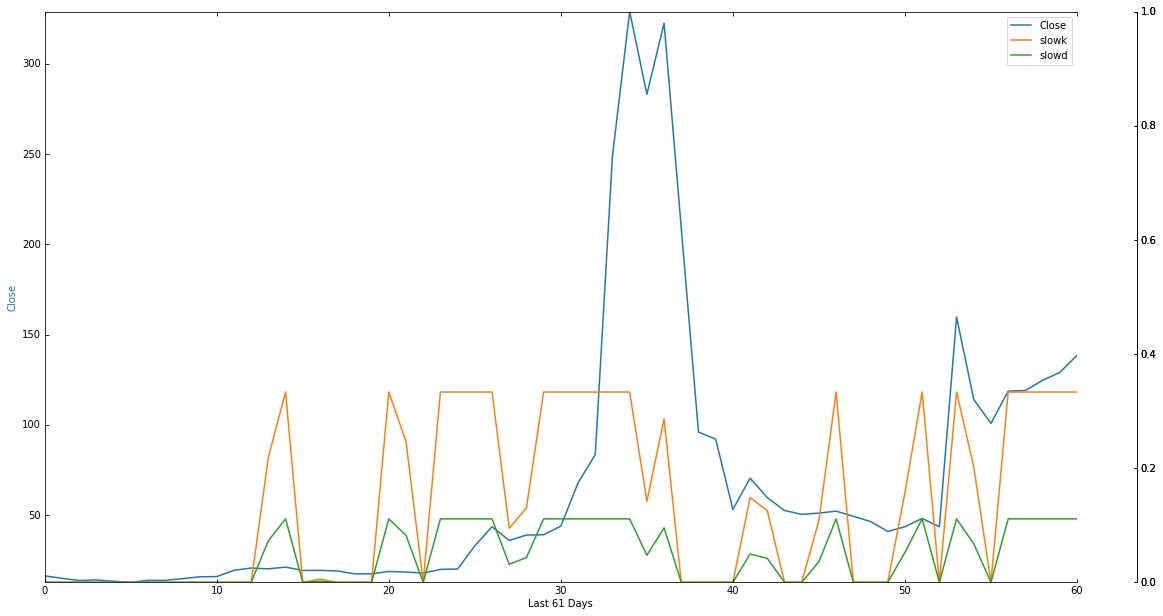

In [6]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import date, timedelta

offset = 60

fig = figure(num=None, figsize=(8, 6), dpi=72, facecolor='w', edgecolor='k')
fig.set_size_inches(18.5, 10.5, forward=True)

host = host_subplot(111, axes_class=AA.Axes)

par1 = host.twinx()
par2 = host.twinx()

new_fixed_axis = par1.get_grid_helper().new_fixed_axis
par1.axis["right"] = new_fixed_axis(loc="right", axes=par1,
                                        offset=(offset, 0))

par1.axis["right"].toggle(all=True)

par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par1.set_ylim(0, 1)
par2.set_ylim(0, 1)

host.set_xlabel("Last {0} Days".format(days))
host.set_ylabel("Close")

chart_data = list(data['c'].tail(days))

host.set_xlim(0, 60)
host.set_ylim(min(chart_data), max(chart_data))

slowk_data = list([i[1] for i in oscillators])

slowd_data = list([i[2] for i in oscillators])

p1, = host.plot(chart_data, label="Close")
p2, = par1.plot(slowk_data, label="slowk")
p3, = par2.plot(slowd_data, label="slowd")

host.legend()

host.axis["left"].label.set_color(p1.get_color())
host.axis["bottom"]
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

In [16]:
def get_market_close(ticker, date, debug = False, pickle = True, include_ah = False):
    market_close = None
    if include_ah:
        market_close = date.replace(hour=18, minute=0, second=0, microsecond=0).astimezone(timezone.utc)
    else:
        market_close = date.replace(hour=16, minute=0, second=0, microsecond=0).astimezone(timezone.utc)
    if debug:
        print("[get_market_close] filtering historical candles by date {0}".format(
        market_close))
    data = fh.get_historical_data(ticker, fh.stock_candles_by_date, include_ah = True)
    data.index = data['t']
    filtered_data = data.loc[market_close]
    return filtered_data

In [17]:
close_data = get_market_close(ticker, datetime.now() + timedelta(days=-1))
close_data_ah = get_market_close(ticker, datetime.now() + timedelta(days=-1), include_ah = True)

/Users/tim/.pyenv/versions/3.8.7/lib/python3.8/site-packages/pandas/core/indexing.py:1124: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return self._get_label(key, axis=axis)
/Users/tim/.pyenv/versions/3.8.7/lib/python3.8/site-packages/pandas/core/indexing.py:1124: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  return self._get_label(key, axis=axis)


In [18]:
close_data

t    2021-03-05 22:00:00
o                 137.25
l                  137.5
h                 138.39
c                  138.5
v                  73104
Name: 2021-03-05 22:00:00, dtype: object

In [19]:
close_data_ah

t    2021-03-06 00:00:00
o                 138.28
l                 138.28
h                 138.28
c                  138.5
v                  42124
Name: 2021-03-06 00:00:00, dtype: object